# Загрузка данных и первичный анализ

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from pathlib import Path
import json

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)
FIGURES_DIR = Path("artifacts/figures")
FIGURES_DIR.mkdir(parents=True, exist_ok=True)


In [3]:
metrics_summary = {}
best_configs = {}

In [4]:
# Диапазон K для KMeans
kmeans_ks = list(range(2, 21))

# Сетка для DBSCAN: eps и min_samples
# eps зависит от масштаба данных – после scaling обычно eps ~ 0.5..5 (но это очень примерно).
dbscan_eps = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
dbscan_min_samples = [3, 5, 10]

# Agglomerative: число кластеров и linkage (для sklearn Agglomerative: 'ward' требует euclidean)
agg_ks = list(range(2, 21))
agg_linkages = ["ward", "complete", "average"]

In [5]:
# Функция для загрузки и EDA анализа

def load_eda(path):
    data = pd.read_csv(path)
    print(data.head(10))
    print("-"*30)
    print(data.info())
    print("-"*30)
    print("Количество пропусков:\n", data.isna().sum())
    print("-"*30)
    print(data.describe())
    X = data.drop(columns=["sample_id"])
    sample_id = data.sample_id
    return X, sample_id

## первый датасет

In [6]:
X_1, sample_id_1 = load_eda("data/S07-hw-dataset-01.csv")

   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   
5          5  -9.155108  80.803958 -0.023064  -42.562391   2.681999   
6          6 -13.414198 -45.224459  0.016343   23.198649   0.275342   
7          7 -15.303931 -39.539061  0.198038   21.117504   0.334350   
8          8 -15.154668 -34.099503  0.215049   18.059247   1.937555   
9          9   0.673476 -82.966506 -0.066941   70.082996 -11.262309   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
5 

В результате проверки данный датасет не имеет пропусков. Все типы столбцов числовые.

## второй датасет

In [7]:
X_2, sample_id_2 = load_eda("data/S07-hw-dataset-02.csv")

   sample_id        x1        x2    z_noise
0          0  0.098849 -1.846034  21.288122
1          1 -1.024516  1.829616   6.072952
2          2 -1.094178 -0.158545 -18.938342
3          3 -1.612808 -1.565844 -11.629462
4          4  1.659901 -2.133292   1.895472
5          5 -0.932356  2.894645  -9.150930
6          6  0.117411  0.834173   4.382666
7          7  1.024343 -1.421237  -3.629838
8          8 -0.468618 -0.296113  -9.568211
9          9 -1.231242 -1.213089  -7.716715
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
None
------------------------------
Количество пропусков:
 sample_id    0
x1           

В результате проверки данный датасет не имеет пропусков. Все типы столбцов числовые.

## третий датасет

In [8]:
X_3, sample_id_3 = load_eda("data/S07-hw-dataset-03.csv")

   sample_id        x1        x2    f_corr   f_noise
0          0 -2.710470  4.997107 -1.015703  0.718508
1          1  8.730238 -8.787416  3.953063 -1.105349
2          2 -1.079600 -2.558708  0.976628 -3.605776
3          3  6.854042  1.560181  1.760614 -1.230946
4          4  9.963812 -8.869921  2.966583  0.915899
5          5 -3.742328  1.064578 -0.286082 -0.284744
6          6 -5.610292  9.366270 -2.713613 -0.129379
7          7  3.875465  2.140182  0.722438 -0.269551
8          8 -7.267612  5.822122 -2.962351 -1.237094
9          9  9.415678  6.038169  3.124603 -0.140653
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float6

В результате проверки данный датасет не имеет пропусков. Все типы столбцов числовые.

# Препроцессинг

In [9]:
# Функция для автматизации препроцессинга
def preproccesing(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    
    return X_scaled

## первый датасет

In [10]:
X_scaled_1 = preproccesing(X_1)

## второй датасет

In [11]:
X_scaled_2 = preproccesing(X_2)

## третий датасет

In [12]:
X_scaled_3 = preproccesing(X_3)

# Модели класстеризации, метрики качества, визуализация

In [13]:
# функция подсчёта метрик и их возвращения в виде json
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None

    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def plot_2d_embedding(emb2d, labels, title, name):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)
    plt.savefig(FIGURES_DIR / name)
    plt.show()

def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))


In [14]:
# функция для перебора и сохранения результатов моделей kmeans
def eval_kmeans_grid(X_feat, ks):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

In [15]:
# функция построения графика silhouette по k и инерция (elbow) по k
def silhouette_plot(kmeans_results, name):
    ks = [r["params"]["k"] for r in kmeans_results]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results]

    plt.figure(figsize=(7, 4))
    plt.plot(ks, sil, marker="o")
    plt.title("KMeans: silhouette vs k")
    plt.xlabel("k")
    plt.ylabel("silhouette")
    plt.grid(True, alpha=0.25)
    plt.savefig(FIGURES_DIR / f"{name}_1.jpg")
    plt.show()

    # Инерция (elbow) – как эвристика
    inertia = [r["inertia"] for r in kmeans_results]
    plt.figure(figsize=(7, 4))
    plt.plot(ks, inertia, marker="o")
    plt.title("KMeans: inertia vs k (elbow heuristic)")
    plt.xlabel("k")
    plt.ylabel("inertia")
    plt.grid(True, alpha=0.25)
    plt.savefig(FIGURES_DIR / f"{name}_2.jpg")
    plt.show()

In [16]:
# функция для перебора и сохранения результатов моделей dbscan (перебор по eps)
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1)) # сохранение для вывода доли шума
            # Метрики считаются по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac), # доля шума
                "n_non_noise": int(mask.sum()),
            })
    return results

In [17]:
# Функция выбора лучшей модели 
def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

In [18]:
# Функция печати результатов лучших моделей
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

In [19]:
# Функция сохранения в json по пути
def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

## первый датасет

### KMEANS

In [20]:
kmeans_results_1 = eval_kmeans_grid(X_scaled_1, kmeans_ks)
len(kmeans_results_1)

19

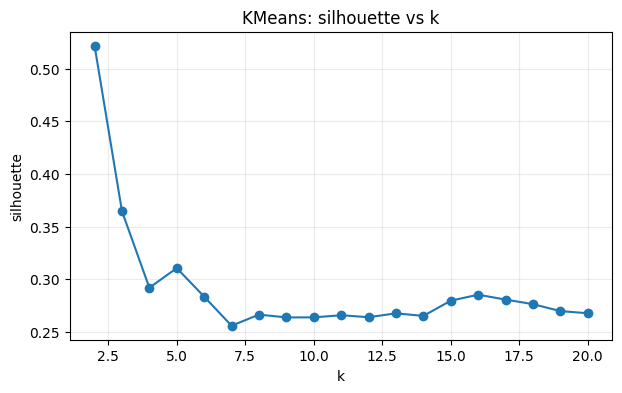

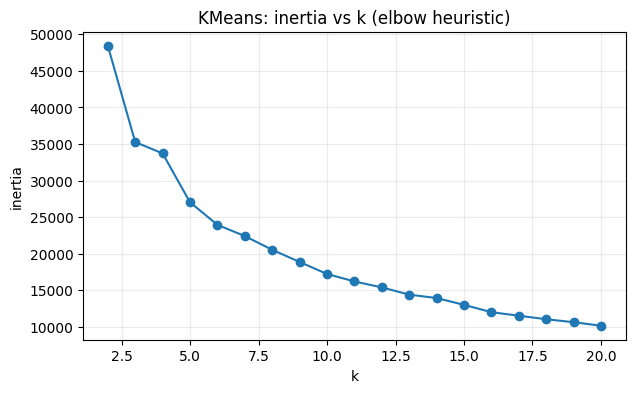

In [21]:
silhouette_plot(kmeans_results_1, "kmeans_ds1") # два графика (silhouette vs k и inertia vs k)

In [22]:
# Выббор лучшей модели KMEANS для первого датасета
best_kmeans_1, best_kmeans_s_1 = pick_best_by_silhouette(kmeans_results_1)
best_kmeans_1["params"], round(best_kmeans_s_1, 3)

({'k': 2}, 0.522)

### DBSCAN

In [23]:
dbscan_results_1 = eval_dbscan_grid(X_scaled_1, dbscan_eps, dbscan_min_samples)
len(dbscan_results_1)

21

In [24]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results_1 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 15
{'eps': 2.0, 'min_samples': 3} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 5} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 10} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 3} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 5} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 10} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 1.5, 'min_samples': 3} sil= 0.397 noise= 0.0 clusters= 3
{'eps': 1.5, 'min_samples': 5} sil= 0.397 noise= 0.0 clusters= 3


In [25]:
best_dbscan_1 = valid_sorted[0] if valid_sorted else None
best_dbscan_1["params"] if best_dbscan_1 else "No valid config found"

{'eps': 2.0, 'min_samples': 3}

### Сводка кандидатов и выбор лучшей модели

In [26]:
metrics_summary["S07-hw-dataset-01"] = {"kmeans": best_kmeans_1["metrics"],
                                        "dbscan": {"metics": best_dbscan_1["metrics"],
                                        "noise_frac": best_dbscan_1["noise_frac"]}}

In [27]:
print_result_card("BEST KMEANS (by silhouette)", best_kmeans_1)
print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan_1)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 2.0, 'min_samples': 3}
n_clusters: 2
noise_frac: 0.0  non-noise: 12000
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0


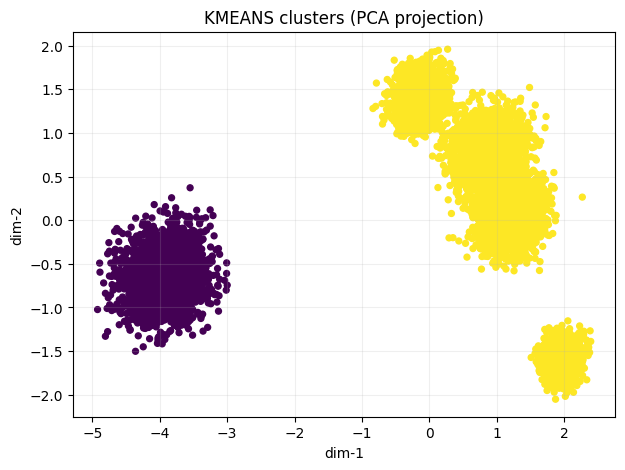

In [28]:
# PCA(2D) визуализация лучшей модели
emb2d_1 = PCA(n_components=2).fit_transform(X_scaled_1)
plot_2d_embedding(emb2d_1, best_kmeans_1["labels"], "KMEANS clusters (PCA projection)", "PCA(2D) scatter_ds1.jpg")

In [29]:
best_configs["S07-hw-dataset-01"] = {"model": "kmeans",
                                     "params": best_kmeans_1["params"],
                                     "selection_criterion": "silhouette"}

## второй датасет

### KMEANS

In [30]:
kmeans_results_2 = eval_kmeans_grid(X_scaled_2, kmeans_ks)
len(kmeans_results_2)

19

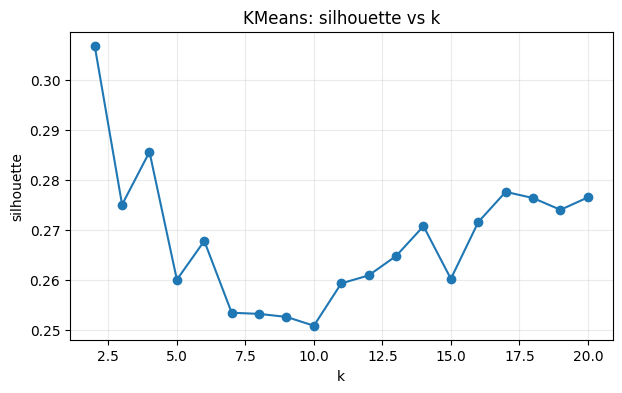

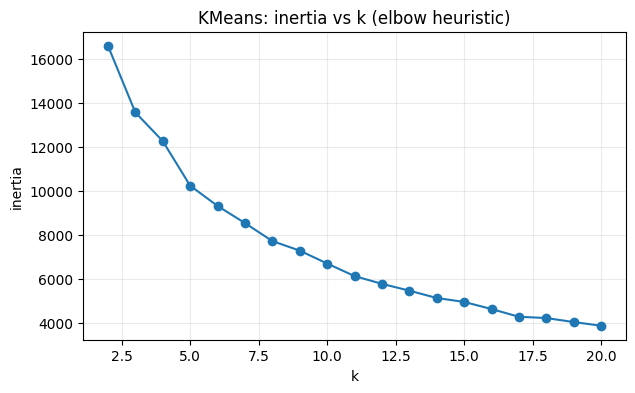

In [31]:
silhouette_plot(kmeans_results_2, "kmeans_ds2") # два графика (silhouette vs k и inertia vs k)

In [32]:
# Выббор лучшей модели KMEANS для второго датасета
best_kmeans_2, best_kmeans_s_2 = pick_best_by_silhouette(kmeans_results_2)
best_kmeans_2["params"], round(best_kmeans_s_2, 3)

({'k': 2}, 0.307)

### DBSCAN

In [33]:
dbscan_results_2 = eval_dbscan_grid(X_scaled_2, dbscan_eps, dbscan_min_samples)
len(dbscan_results_2)

21

In [34]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results_2 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 3
{'eps': 0.5, 'min_samples': 10} sil= 0.251 noise= 0.064 clusters= 2
{'eps': 0.5, 'min_samples': 5} sil= -0.058 noise= 0.045 clusters= 14
{'eps': 0.5, 'min_samples': 3} sil= -0.063 noise= 0.025 clusters= 32


In [35]:
best_dbscan_2 = valid_sorted[0] if valid_sorted else None
best_dbscan_2["params"] if best_dbscan_2 else "No valid config found"

{'eps': 0.5, 'min_samples': 10}

### Сводка кандидатов и выбор лучшей модели

In [36]:
metrics_summary["S07-hw-dataset-02"] = {"kmeans": best_kmeans_2["metrics"],
                                        "dbscan": {"metics": best_dbscan_2["metrics"],
                                        "noise_frac": best_dbscan_2["noise_frac"]}}

In [37]:
print_result_card("BEST KMEANS (by silhouette)", best_kmeans_2)
print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan_2)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.307
  davies_bouldin: 1.323
  calinski_harabasz: 3573.4
  inertia: 16588.5
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 0.5, 'min_samples': 10}
n_clusters: 2
noise_frac: 0.064  non-noise: 7491
metrics:
  silhouette: 0.251
  davies_bouldin: 0.742
  calinski_harabasz: 26.2


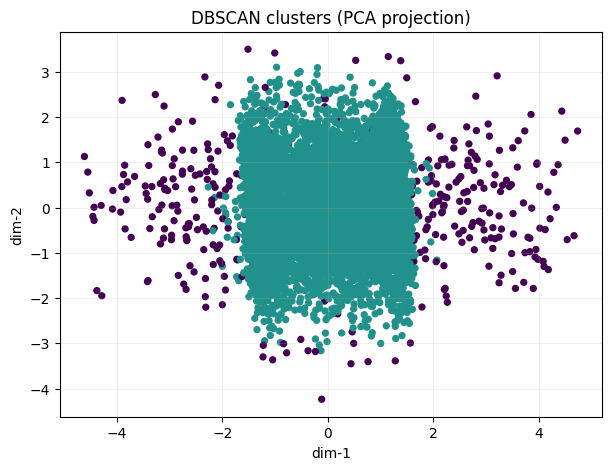

In [38]:
# PCA(2D) визуализация лучшей модели
emb2d_2 = PCA(n_components=2).fit_transform(X_scaled_2)
plot_2d_embedding(emb2d_2, best_dbscan_2["labels"], "DBSCAN clusters (PCA projection)", "PCA(2D) scatter_ds2.jpg")

In [39]:
best_configs["S07-hw-dataset-02"] = {"model": "dbscan",
                                     "params": best_dbscan_2["params"],
                                     "selection_criterion": "PCA projection"}

## третий датасет

### KMEANS

In [40]:
kmeans_results_3 = eval_kmeans_grid(X_scaled_3, kmeans_ks)
len(kmeans_results_3)

19

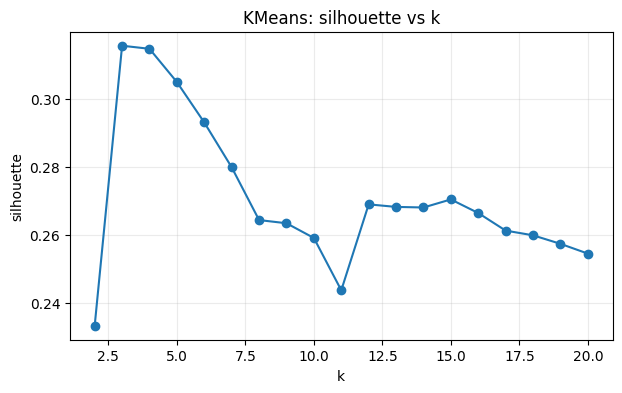

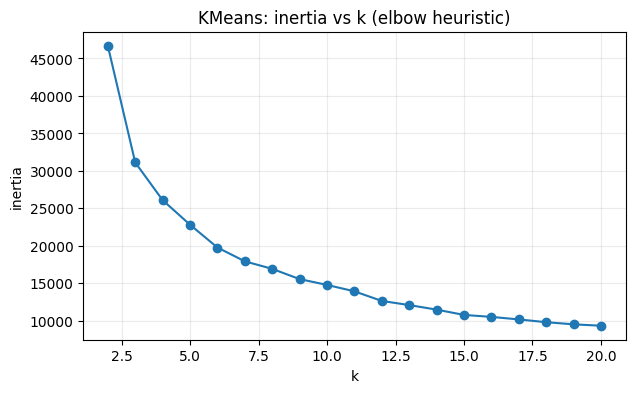

In [41]:
silhouette_plot(kmeans_results_3, "kmeans_ds3") # два графика (silhouette vs k и inertia vs k)

In [42]:
# Выббор лучшей модели KMEANS для третьего датасета
best_kmeans_3, best_kmeans_s_3 = pick_best_by_silhouette(kmeans_results_3)
best_kmeans_3["params"], round(best_kmeans_s_3, 3)

({'k': 3}, 0.316)

### DBSCAN

In [43]:
dbscan_results_3 = eval_dbscan_grid(X_scaled_3, dbscan_eps, dbscan_min_samples)
len(dbscan_results_3)

21

In [44]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results_3 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 3
{'eps': 0.5, 'min_samples': 10} sil= 0.142 noise= 0.032 clusters= 2
{'eps': 0.5, 'min_samples': 5} sil= -0.104 noise= 0.022 clusters= 4
{'eps': 0.5, 'min_samples': 3} sil= -0.232 noise= 0.016 clusters= 12


In [45]:
best_dbscan_3 = valid_sorted[0] if valid_sorted else None
best_dbscan_3["params"] if best_dbscan_3 else "No valid config found"

{'eps': 0.5, 'min_samples': 10}

### Сводка кандидатов и выбор лучшей модели

In [46]:
metrics_summary["S07-hw-dataset-03"] = {"kmeans": best_kmeans_3["metrics"],
                                        "dbscan": {"metics": best_dbscan_3["metrics"],
                                        "noise_frac": best_dbscan_3["noise_frac"]}}

In [47]:
print_result_card("BEST KMEANS (by silhouette)", best_kmeans_3)
print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan_3)

BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 3}
n_clusters: 3
metrics:
  silhouette: 0.316
  davies_bouldin: 1.158
  calinski_harabasz: 6957.2
  inertia: 31123.5
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 0.5, 'min_samples': 10}
n_clusters: 2
noise_frac: 0.032  non-noise: 14514
metrics:
  silhouette: 0.142
  davies_bouldin: 1.393
  calinski_harabasz: 1640.8


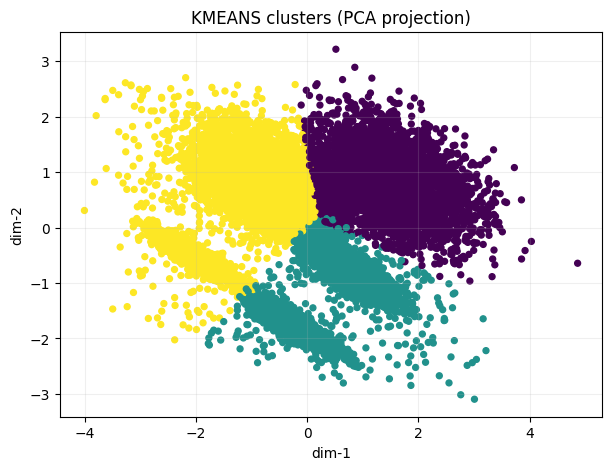

In [48]:
# PCA(2D) визуализация лучшей модели
emb2d_3 = PCA(n_components=2).fit_transform(X_scaled_3)
plot_2d_embedding(emb2d_3, best_kmeans_3["labels"], "KMEANS clusters (PCA projection)", "PCA(2D) scatter_ds3.jpg")

In [49]:
best_configs["S07-hw-dataset-03"] = {"model": "kmeans",
                                     "params": best_kmeans_3["params"],
                                     "selection_criterion": "silhouette"}

## интерпритация кластеров

In [60]:
def interp_clasters_median(X, model):
    df = pd.DataFrame(X)
    df['cluster'] = model['labels']
    cluster_profiles = df[df['cluster'] != -1].groupby('cluster').median()
    return cluster_profiles

In [68]:
interp_clasters_median(X_1, best_kmeans_1)

,f01,f02,f03,f04,f05,f06,f07,f08
cluster,,,,,,,,
0,17.597315,59.885279,-1.195421,-102.572373,10.059095,29.259364,-2.262072,-0.014286
1,-7.851184,14.877104,-0.003984,20.629080,-1.872523,-7.418370,-0.362257,0.010276


In [67]:
interp_clasters_median(X_2, best_dbscan_2)

,x1,x2,z_noise
cluster,,,
0,0.49850,0.243122,0.093795
1,2.17313,1.319523,0.485348


In [66]:
interp_clasters_median(X_3, best_kmeans_3)

,x1,x2,f_corr,f_noise
cluster,,,,
0,6.777198,5.835115,1.127508,-0.100227
1,3.550189,-2.387896,1.303351,-0.073593
2,-2.320274,2.860659,-1.153534,-0.025767


# Устойчивость

5 запусков с разным random state с оценкой похожести разбиений по ARI между результатами. Будет использоваться первый датасет

In [50]:
n_runs = 5
labels_list = []

for i in range(n_runs):
    kmeans = KMeans(n_clusters=4, random_state=i, n_init=10)
    labels = kmeans.fit_predict(X_scaled_1)
    labels_list.append(labels)

# Посчитаем попарные ARI
ari_matrix = np.zeros((n_runs, n_runs))
for i in range(n_runs):
    for j in range(n_runs):
        ari_matrix[i, j] = adjusted_rand_score(labels_list[i], labels_list[j])

# Среднее значение ARI (без диагонали)
upper_tri = ari_matrix[np.triu_indices_from(ari_matrix, k=1)]
mean_ari = np.mean(upper_tri)


In [51]:
mean_ari

np.float64(1.0)

Проверка устойчивости дала результат ARI равной 1, что говорит о высокой устойчивости модели на данном датасете

# Итоги по каждому датасету

## первый датасет

Обе модели получилсь одинаковыми по всем метрикам и количеству кластеров как это не странно. Можно выбрать любую модель.

Получилась модель с максимальным silhouette. Сложностей не было. KMEANS обеспечивает максимальный silhouette.

## второй датасет

По метрике silhouette более предпочтителен метод KMEANS, но по Davies-Bouldin и PCA(2D) визуализации показывает более лучшую картину метод DBSCAN, поэтому лучшим для второго датасета является метод DBSCAN.

Была получина модель для второго датасета. Сложностей не было. DBSCAN обеспечивает более лучшие результаты для второго датасета, поскольку данные расположены довольно плотно и KMEANS может быть хуже.

## третий датасет

Для третьего датасета был выбран KMeans с k=3, несмотря на умеренное значение silhouette (0.316), потому что он дал более содержательное и устойчивое разбиение по сравнению с DBSCAN.  

Сложностей не было. Выбор KMeans обоснован стремлением получить интерпретируемое разбиение на три группы без потери значительной доли объектов как шума.

# Сохранение артефактов

In [52]:
def save_labels(sample_id, labels, name):
    result_df = pd.DataFrame({
    'sample_id': sample_id,
    'cluster_label': labels
    })
    result_df.to_csv(ARTIFACTS_DIR / "labels" / name, index=False)

In [53]:
save_json(metrics_summary, ARTIFACTS_DIR / "metrics_summary.json")
save_json(best_configs, ARTIFACTS_DIR / "best_configs.json")

In [54]:
save_labels(sample_id_1, best_kmeans_1["labels"], "labels_ hw07_ds1.csv")
save_labels(sample_id_2, best_dbscan_2["labels"], "labels_ hw07_ds2.csv")
save_labels(sample_id_3, best_kmeans_3["labels"], "labels_ hw07_ds3.csv")